# Advanced features

This tutorial covers usage of advanced features of ReservoirPy for Reservoir Computing architectures:

- Input-to-readout connections and other complicated connections
- Feedback connections
- Generation and long term forecasting
- Custom weight matrices
- Parallelization
- "Deep" architectures

To go further, the [`examples/`](https://github.com/reservoirpy/reservoirpy/tree/master/examples) folder contains example of complex use cases from the literature.

In [2]:
import reservoirpy as rpy

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everyhting reproducible !

During this tutorial, we will be using the same task as introduced in the "Getting started" tutorial: we create 100 samples of a sine wave, and divide these 100 timesteps between a 50 timesteps training timeseries and 50 timesteps testing timeseries. 

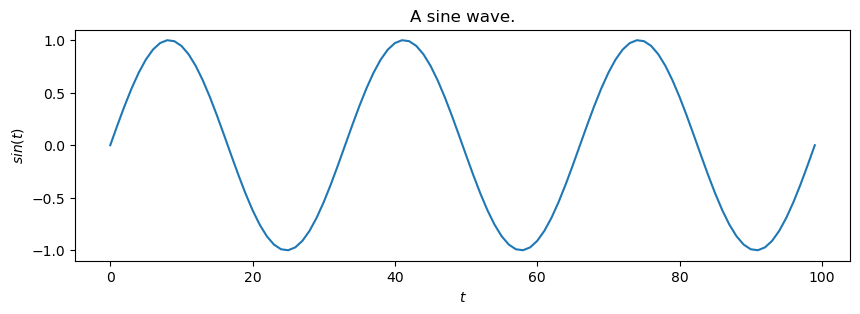

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)

X_train = X[:50]
Y_train = X[1:51]

plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

## Input-to-readout connections

More advanced ESNs may include direct connections from input to readout. This can be achieved using the `Input` node and advanced features of model creation: connection chaining with the `>>` operator and connection merge using the `&` operator.

In [4]:
from reservoirpy.nodes import Reservoir, Ridge, Input

data = Input()
reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = data >> reservoir >> readout & data >> readout

The `&` operator can be used to merge two Model together. 
Here, we first connect the input to the reservoir and the reservoir to the readout. As models are a subclass of nodes, it is also possible to apply the `>>` on models, allowing chaining. When a model is connected to a node, all output nodes of the model are automatically connected to the node. A new model storing all the nodes involved in the process, along with all their connections, is created.

```python
connection_1 = data >> reservoir >> readout

```

Then, we define another model connecting the input to the readout.

```python
connection_2 = data >> readout
```

Finally, we merge all connections into a single model:

```python
esn_model = connection_1 & connection_2
```

A same model can be obtained using another syntax, taking advantage of many-to-one and one-to-many connections. These type of connections are created using iterables of nodes:

In [5]:
esn_model = [data, data >> reservoir] >> readout

In that case, we plug two models into the readout: `data` alone and `data >> reservoir`. This is equivalent to the syntax of the first example.

Note that most nodes can not receive several inputs at once. It is the case of our readout node here. To tackle this problem, many-to-one connections will automatically trigger the creation of a special `Concat` node. This node will concatenate all incoming vectors before feeding them to the reciever node, here the readout.

Our `esn_model` hence have 4 nodes, and not 3:

In [6]:
esn_model.node_names

['Input-0', 'Reservoir-0', 'Concat-1', 'Ridge-0']

It is possible to explicitely create this model using the `Concat` node:

In [7]:
from reservoirpy.nodes import Reservoir, Ridge, Input, Concat

data = Input()
reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)
concatenate = Concat()

esn_model = [data, data >> reservoir] >> concatenate >> readout

In [8]:
esn_model.node_names

['Input-1', 'Reservoir-1', 'Concat-2', 'Ridge-1']

## Feedback connections

Feedback connections are another important feature of ESNs. All nodes in ReservoirPy can be connected through feedback connections. Once a feedback connection is established between two nodes, the feedback receiver can access the state of the feedback sender anytime. When running on a timeseries, **this access will hence allow the receiver to access the state of the sender, with a time delay of one timestep**. 

To declare a feedback connection between two nodes, you can use the `<<` operator. This operator will create a copy of the receiver holding a reference to the sender. If you do not want to copy the receiver, use the inplace operator `<<=`.

Let's add a feedback connection between our readout and our reservoir. This way, the reservoir will have access to the readout's last activation using the `feedback()` method:

In [9]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

reservoir <<= readout

esn_model = reservoir >> readout

Once all nodes are initialized - after training the model for instance - feedback is available:

In [10]:
esn_model = esn_model.fit(X_train, Y_train)

In [11]:
esn_model(X[0].reshape(1, -1))

print("Feedback received (reservoir):", reservoir.feedback())
print("State sent: (readout):", readout.state())

Feedback received (reservoir): [[-0.23879726]]
State sent: (readout): [[-0.23879726]]


### Forced feedbacks

Note that adding feedback may slightly change the training procedure. In most cases, we need **teacher forcing** to obtain convergence: teacher vectors $Y$ are used as feedback for the reservoir while readout is not trained.

This behavior can be modified using the `force_teachers` parameter of the `Model.fit()` method:

In [12]:
esn_model = esn_model.fit(X_train, Y_train, force_teachers=True)  # by default

Feedback may also change the behavior of the `run()` method of models. Indeed, if feedback senders like readouts are not available at run time, it might be necessary to provide a feedback timeseries to the receiver node to replace the missing feedback signal. This can be done using the `forced_feedback` parameter of the `Model.run()` method:

In [30]:
pred = esn_model.run(X_train, forced_feedbacks=Y_train, shift_fb=True)

Pay also attention to the `shift_fb` parameter. This parameter indicates that the forced feedback timeseries should be shifted in time by one timestep. In the code above, `Y_train` is a timeseries of same shape as `X_train`. But teacher values in `Y_train` should not be received by the reservoir *at the same time* as inputs from `X_train`. These values are supposed to be feedbacks, and therefore need to be received *one timesteps after the corresponding input*. To enforce this behavior, we set the `shift_fb` parameter to `True`.

Finally, you can also use the `with_feedback()` context manager to change the feedback received by a node anytime. This context manager acts the same way as the `with_state()` context manager described in the "Getting started" tutorial. It can be either used on the feedback sender or receiver, and only requires them to be initialized.

In [15]:
random_feedback = np.random.normal(0, 1, size=(1, readout.output_dim))

with reservoir.with_feedback(random_feedback):
    reservoir(X[0].reshape(1, -1))

## Generation and long term forecasting

In this section, we will see how to use ReservoirPy nodes and models to perform long term forecasting or timeseries generation.

We will take a simple ESN as an example:

In [32]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

Imagine that we now desire to predict the 100 next steps of the timeseries, given its 10 last steps.

In order to achieve this kind of prediction with an ESN, we first train the model on the simple one-timestep-ahead prediction task defined in the sections above:

In [33]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)

Now that our ESN is trained on that simple task, we reset its internal state and feed it with the 10 last steps of the training timeseries.

In [34]:
warmup_y = esn_model.run(X_train[:-10], reset=True)

This updated the state of the reservoir inside the ESN to some value. We assume that this value is representative of the dynamics of these 10 timesteps.

Based on this state, we will now predict the next step in the timeseries. Then, this predicted step will be fed to the ESN again, and so on 50 times, to generate the 50 following timesteps. In other words, the ESN is running over its own predictions.

In [35]:
Y_pred = np.empty((100, 1))
x = warmup_y[-1].reshape(1, -1)

for i in range(100):
    x = esn_model(x)
    Y_pred[i] = x

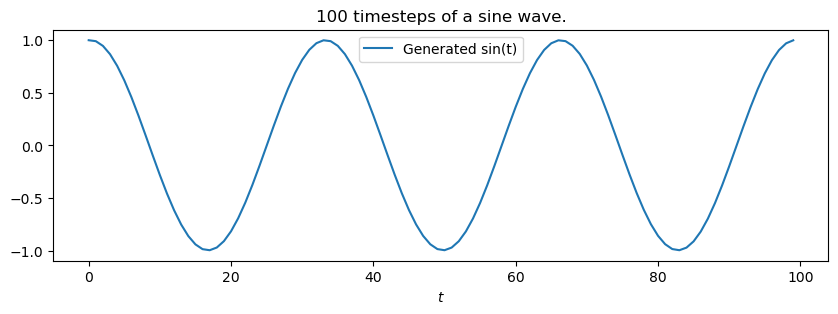

In [36]:
plt.figure(figsize=(10, 3))
plt.title("100 timesteps of a sine wave.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Generated sin(t)")
plt.legend()
plt.show()

The long term forecasting ability of ESNs are one of their most impressive features. You have seen in this section how to perform this kind of generative task using a for-loop and an ESN call method.

## Custom weight matrices

### From custom initializer functions

Readouts and reservoirs hold parameters stored as Numpy array or Scipy sparse matrices. These parameters can be initialized at first run of the node. This initialization is performed by calling initializer functions, which take as parameters the shape of the parameter matrix and return an array or a Scipy matrix. Initializer functions can be passed as parameter to reservoirs or readouts:

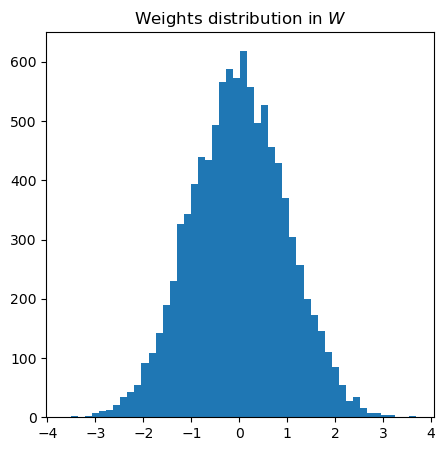

In [37]:
from reservoirpy.nodes import Reservoir

def normal_w(n, m, **kwargs):
    return np.random.normal(0, 1, size=(n, m))

reservoir = Reservoir(100, W=normal_w)

reservoir(X[0].reshape(1, -1))

plt.figure(figsize=(5, 5))
plt.title("Weights distribution in $W$")
plt.hist(reservoir.W.ravel(), bins=50)
plt.show()

### From reservoirpy.mat_gen module

The `reservoirpy.mat_gen` module contains ready-to-use initializers able to create weights from any `scipy.stats` distribution, along with some more specialized initializations functions.

Below are some examples:

In [39]:
from reservoirpy.mat_gen import random_sparse

# Random sparse matrix initializer from uniform distribution,
# with spectral radius to 0.9 and connectivity of 0.1.

# Matrix creation can be delayed...
initializer = random_sparse(
    dist="uniform", sr=0.9, connectivity=0.1)
matrix = initializer(100, 100)

# ...or can be performed right away.
matrix = random_sparse(
    100, 100, dist="uniform", sr=0.9, connectivity=0.1)

from reservoirpy.mat_gen import normal

# Dense matrix from Gaussian distribution,
# with mean of 0 and variance of 0.5
matrix = normal(50, 100, loc=0, scale=0.5)

from reservoirpy.mat_gen import uniform

# Sparse matrix from uniform distribution in [-0.5, 0.5],
# with connectivity of 0.9 and input_scaling of 0.3.
matrix = uniform(
    200, 60, low=0.5, high=0.5, 
    connectivity=0.9, input_scaling=0.3)

from reservoirpy.mat_gen import bernoulli

# Sparse matrix from a Bernoulli random variable
# giving 1 with probability p and -1 with probability 1-p,
# with p=0.5 (by default) with connectivity of 0.2
# and fixed seed, in Numpy format.
matrix = bernoulli(
    10, 60, connectivity=0.2, sparsity_type="dense")

This functions can be tuned and integrated to any Node accepting initializer functions. In particular, they can be used to tune parameters distribution in a reservoir.

### From Numpy arrays or Scipy sparse matrices

In addition to initializer functions, parameters can be initialized using Numpy arrays or Scipy sparse matrices of correct shape.

In [40]:
from reservoirpy.nodes import Reservoir

W_matrix = np.random.normal(0, 1, size=(100, 100))
bias_vector = np.ones((100, 1))

reservoir = Reservoir(W=W_matrix, bias=bias_vector)

states = reservoir(X[0].reshape(1, -1))

## Parallelization of ESN training/running

Using the special node `reservoirpy.nodes.ESN`, it is possible to perform ESN offline training with ridge regression in a distributed way. We use `joblib` to exploit multiprocessing when computing node states over independent sequences of inputs.

In the following example, we will consider a dataset made of 500 independent sequences of inputs (and their corresponding 500 sequences of target values). These sequences could be 500 independent spoken sentences, or audio files, or episodes of a robotic simulation. The sequences or timeseries do not need to have the same length in practice. Here, they are all 1000 timesteps long, and are 50-dimensional. Targets sequences number and length need to match exactly those of inputs, but can have a different dimensionality. In the example below, they are 40-dimensional.

In [41]:
X = np.array([[np.sin(np.linspace(0, 12*np.pi, 1000)) 
               for j in range(50)] 
              for i in range(500)]).reshape(-1, 1000, 50)

Y = np.array([[np.sin(np.linspace(0, 12*np.pi, 1000))
               for j in range(40)] 
              for i in range(500)]).reshape(-1, 1000, 40)

print(X.shape, Y.shape)

(500, 1000, 50) (500, 1000, 40)


An `reservoirpy.nodes.ESN` can be created from the standard `Reservoir` and `Ridge` nodes. Then, it acts as any other node in ReservoirPy, excepts it can not be integrated in a Model.

We set the `workers` parameter of the ESN to `-1`, to enable parallelization over all available processes. You can also specify a number above 0 to restrain the number of processes used to train and run the node.

In [42]:
from reservoirpy.nodes import Reservoir, Ridge, ESN
import time

reservoir = Reservoir(100, lr=0.3, sr=1.0)
readout = Ridge(ridge=1e-6)

esn = ESN(reservoir=reservoir, readout=readout, workers=-1)

start = time.time()
esn = esn.fit(X, Y)
print("Parallel (multiprocessing):", 
      "{:.2f}".format(time.time() - start), "seconds")

esn = ESN(reservoir=reservoir, readout=readout, backend="sequential")

start = time.time()
esn = esn.fit(X, Y)
print("Sequential:", 
      "{:.2f}".format(time.time() - start), "seconds")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

Parallel (multiprocessing): 4.14 seconds
Sequential: 18.31 seconds


## "Deep" architectures

Nodes can be combined in any way to create deeper structure than just a reservoir and a readout.
Connecting nodes together can be done by chaining the `>>` and the ``&`` operator.

- The `>>` operator allows to compose nodes to form a chain model. Data flows from node to node in the chain.

- The `&` operator allows to merge models together, to create parallel pathways. Merging two chains of nodes will create a new model containing all the nodes in the two chains along with all the connections between them.

Below are examples of so called *deep echo state networks*, from schema to code, illustrating the use of these two operators. More extensive explanations about complex models can be found in the [From Nodes to Models](https://reservoirpy.readthedocs.io/en/latest/user_guide/model.html) documentation.

### Example 1 - Hierarchical ESN

![](./static/deep1.svg)

In [26]:
from reservoirpy.nodes import Reservoir, Ridge, Input


reservoir1 = Reservoir(100, name="res1-1")
reservoir2 = Reservoir(100, name="res2-1")

readout1 = Ridge(ridge=1e-5, name="readout1-1")
readout2 = Ridge(ridge=1e-5, name="readout2-1")

model = reservoir1 >> readout1 >> reservoir2 >> readout2

This model can be trained by explicitely delivering targets to each readout using a dictionnary:

In [27]:
model = model.fit(X_train, {"readout1-1": Y_train, "readout2-1": Y_train})

### Exemple 2 - Deep ESN

![](./static/deep2.svg)

In [28]:
from reservoirpy.nodes import Reservoir, Ridge, Input


reservoir1 = Reservoir(100, name="res1-2")
reservoir2 = Reservoir(100, name="res2-2")
reservoir3 = Reservoir(100, name="res3-2")

readout = Ridge(name="readout-2")

model = reservoir1 >> reservoir2 >> reservoir3 & \
        data >> [reservoir1, reservoir2, reservoir3] >> readout

### Exemple 3 - Multi-inputs

![](./static/deep3.svg)

In [29]:
from reservoirpy.nodes import Reservoir, Ridge, Input


reservoir1 = Reservoir(100, name="res1-3")
reservoir2 = Reservoir(100, name="res2-3")
reservoir3 = Reservoir(100, name="res3-3")

readout1 = Ridge(name="readout2")
readout2 = Ridge(name="readout1")

model = [reservoir1, reservoir2] >> readout1 & \
        [reservoir2, reservoir3] >> readout2